# Square Gradient Theory for Mixtures

This notebook has te purpose of showing examples of computing interfacial tension of mixtures and beta = 0.

First it's needed to import the necessary modules

In [1]:
import numpy as np
from phasepy import component, mixture, prsveos
from phasepy.equilibrium import bubblePy
from phasepy.sgt import sgt_mix_beta0
import matplotlib.pyplot as plt

Then a mixture and the EoS are created. With the EoS a equilibrium point is computed, in this case the bubble point of a mixture of x1 = 0.3 at 320K.


In [2]:
#component creation
water =  component(name = 'Water', Tc = 647.13, Pc = 220.55, Zc = 0.229, Vc = 55.948, w = 0.344861,
                ksv = [ 0.87185176, -0.06621339],
                cii = [2.06553362e-26, 2.64204784e-23, 4.10320513e-21],
                GC = {'H2O':1})

ethanol = component(name = 'Ethanol', Tc = 514.0, Pc = 61.37, Zc = 0.241, Vc = 168.0, w = 0.643558,
                ksv = [1.27092923, 0.0440421 ],
                cii = [ 2.35206942e-24, -1.32498074e-21,  2.31193555e-19],
                GC = {'CH3':1, 'CH2':1, 'OH(P)':1})

mix = mixture(ethanol, water)
mix.unifac()
eos1 = prsveos(mix, 'mhv_unifac')

T = 320 #K
X = np.array([0.3, 0.7])
P0 = 0.3 #bar
Y0 = np.array([0.7, 0.3])

#The full_output option allows to obtain the compositions and volume of the phases
sol = bubblePy(Y0, P0, X, T, eos1, full_output = True)
Y = sol.Y
P = sol.P
vl = sol.v1
vv = sol.v2

#computing the density vector
rhol = X / vl
rhov = Y / vv

If the ```full_output``` is set to false, the densities of the phases can be computed as:

In [3]:
rhol = eos1.density(X, T, P, 'L') * X
rhov = eos1.density(Y, T, P, 'V') * Y 

With the computed equilibrium value SGT can be used to study the interfacial behavior of the mixture.

In [4]:
#if reference component is set to ethanol (index = 0) a lower value is obtained as the 
#full density profile was not calculated because of a stationary point in the interface
solr1 = sgt_mix_beta0(rhov, rhol, T, P, eos1, s = 0, n = 100, method = 'reference', full_output = True)

#water doesnt show surface activity across the interface and the density profiles are fully calculated
solr2 = sgt_mix_beta0(rhov, rhol, T, P, eos1, s = 1, n = 100, method = 'reference', full_output = True)

#Using Liang path function the density profiles are computed directly
soll = sgt_mix_beta0(rhov, rhol, T, P, eos1, n= 500, method = 'liang', full_output = True)

#Cornelisse path function also allows to compute the density profiles
solc = sgt_mix_beta0(rhov, rhol, T, P, eos1, n = 500, method = 'cornelisse', full_output = True)

C:\Users\boltzmann\miniconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [5]:
print('Reference component method (1) : ', solr1.tension, 'mN/m')
print('Reference component method (2) : ', solr2.tension, 'mN/m')
print('Liang path Function (1) : ', soll.tension, 'mN/m')
print('Cornelisse path Function (1) : ', solc.tension, 'mN/m')

Reference component method (1) :  15.816492169904194 mN/m
Reference component method (2) :  27.285131501639658 mN/m
Liang path Function (1) :  27.28453369124229 mN/m
Cornelisse path Function (1) :  27.284274705232814 mN/m


The ```full_output``` options allows to obtain tension value, density profiles and grand thermodynamic potential.
Those values are accessed similar as SciPy OptimizeResult.

1. sol.tension -> calculated IFT
2. sol.rho -> density array
3. sol.z -> interfacial lenght array
4. sol.GPT -> grand thermodynamic potential


The results can be plotted an compared. As can be seen, when ethanol is used as a reference component this method is not able to compute the density profile from one bulk phase to another.
When studying the alpha variable from Liang path function it can be seen that its value at the edge is zero as well as somehwehre in the middle. This is expected when the geometric mean rule for the influence parameter with no correction can be used for the mixture.

Text(0.5, 0, 'path function')

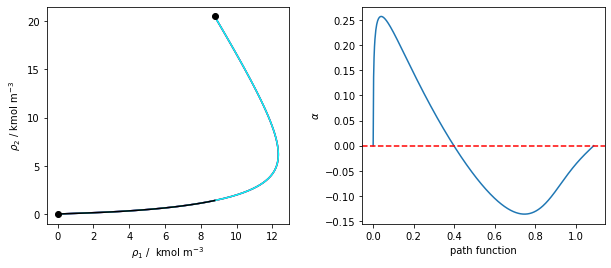

In [6]:
rhor1 = 1000 * solr1.rho #kmol/m3
rhor2 = 1000 * solr2.rho #kmol/m3

rholiang = 1000 * soll.rho #kmol/m3
alphas = soll.alphas
path = soll.path

rhoc = 1000* solc.rho


fig = plt.figure(figsize = (10, 4))
fig.subplots_adjust( wspace=0.3)
ax1 = fig.add_subplot(121)
ax1.plot(rhoc[0], rhoc[1], color = 'blue')
ax1.plot(rholiang[0], rholiang[1], color = 'red')
ax1.plot(rhor2[0], rhor2[1], color = 'cyan')
ax1.plot(rhor1[0], rhor1[1], color = 'black')
ax1.plot(1000* rhov[0], 1000*rhov[1], 'o', color = 'k')
ax1.plot(1000*rhol[0], 1000*rhol[1], 'o', color = 'k')
ax1.set_xlabel(r'$\rho_1$ /  kmol m$^{-3}$')
ax1.set_ylabel(r'$\rho_2$ / kmol m$^{-3}$')

ax2 = fig.add_subplot(122)
ax2.plot(path, alphas)
ax2.axhline(y = 0, linestyle = '--',color = 'r')
ax2.set_ylabel(r'$\alpha$')
ax2.set_xlabel(r'path function')

A more challenging mixture to analyze is ethanol and hexane. This mixture has several stationary points across the interface making its calculations tricky. Similar as before, equilibrium has to be computed. 

In [7]:
hexane = component(name = 'n-Hexane', Tc = 507.6, Pc = 30.25, Zc = 0.266, Vc = 371.0, w = 0.301261, 
                ksv = [ 0.81185833, -0.08790848],
                cii = [ 5.03377433e-24, -3.41297789e-21,  9.97008208e-19],
                GC = {'CH3':2, 'CH2':4})

mix = mixture(ethanol, hexane)

a12, a21 = np.array([1141.56994427,  125.25729314])
A = np.array([[0, a12], [a21, 0]])
mix.wilson(A)

eos2 = prsveos(mix, 'mhv_wilson')

T = 320 #K
X = np.array([0.3, 0.7])
P0 = 0.3 #bar
Y0 = np.array([0.7, 0.3])

sol = bubblePy(Y0, P0, X, T, eos2, full_output = True)
Y = sol.Y
P = sol.P
vl = sol.v1
vv = sol.v2

#computing the density vector
rhol = X / vl
rhov = Y / vv

Then SGT is used with the different methods available for beta = 0

In [8]:
solr1 = sgt_mix_beta0(rhov, rhol, T, P, eos2, s = 0, n = 100, method = 'reference', full_output = True)
solr2 = sgt_mix_beta0(rhov, rhol, T, P, eos2, s = 1, n = 100, method = 'reference', full_output = True)

soll = sgt_mix_beta0(rhov, rhol, T, P, eos2, n= 500, method = 'liang', full_output = True)

solc = sgt_mix_beta0(rhov, rhol, T, P, eos2, n= 500, method = 'cornelisse', full_output = True)

C:\Users\boltzmann\miniconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\boltzmann\miniconda3\lib\site-packages\phasepy-0.0.35-py3.7-win-amd64.egg\phasepy\cubic\cubicmix.py:519: RuntimeWarning: invalid value encountered in log
  g = np.log( V_B  / V)
C:\Users\boltzmann\miniconda3\lib\site-packages\phasepy-0.0.35-py3.7-win-amd64.egg\phasepy\cubic\cubicmix.py:520: RuntimeWarning: invalid value encountered in log
  f = np.log(Vc1B / Vc2B) / (R * B * (c1 - c2))
C:\Users\boltzmann\miniconda3\lib\site-packages\phasepy-0.0.35-py3.7-win-amd64.egg\phasepy\cubic\cubicmix.py:532: RuntimeWarning: invalid value encountered in log
  mui = np.log(RT_V) + np.log(X) + 1.


In [9]:
print('Reference component method (1) : ', solr1.tension, 'mN/m')
print('Reference component method (2) : ', solr2.tension, 'mN/m')
print('Liang path Function (1) : ', soll.tension, 'mN/m')
print('Cornelisse path Function (1) : ', solc.tension, 'mN/m')

Reference component method (1) :  12.920799769272866 mN/m
Reference component method (2) :  15.586998508395448 mN/m
Liang path Function (1) :  12.998496227356462 mN/m
Cornelisse path Function (1) :  15.645030807866085 mN/m


Finally, the density profiles can be plotted. As can be seen, only Cornelisse path function is able to compute the density profiles from one bluk phase to another correctly. Reference method and Liang path function stop a one of the stationary points. 

When studying the alpha variable from Liang path function it can be seen that the end value is not zero. This variable should take the value of zero at three values: at the edges and somewehre in the middle. This is a clear sign that the geometric mean rule for the influence parameter is not suitable for this mixture. 

Text(0.5, 0, 'path function')

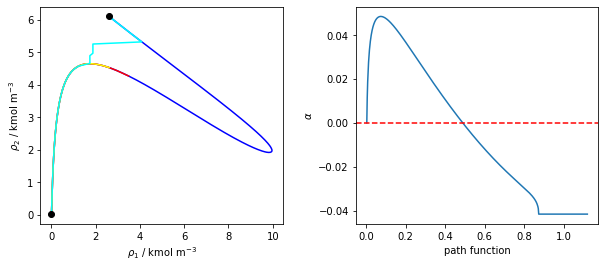

In [10]:
rhor1 = 1000 * solr1.rho #kmol/m3
rhor2 = 1000 * solr2.rho #kmol/m3

rholiang = 1000 * soll.rho #kmol/m3
alphas = soll.alphas
path = soll.path

rhoc = 1000* solc.rho

fig = plt.figure(figsize = (10, 4))
fig.subplots_adjust( wspace=0.3)
ax1 = fig.add_subplot(121)
ax1.plot(rhoc[0], rhoc[1], color = 'blue')
ax1.plot(rholiang[0], rholiang[1], color = 'red')
ax1.plot(rhor1[0], rhor1[1], color = 'yellow')
ax1.plot(rhor2[0], rhor2[1], color = 'cyan')
ax1.plot(1000 * rhov[0], 1000*rhov[1], 'o', color = 'k')
ax1.plot(1000 * rhol[0], 1000*rhol[1], 'o', color = 'k')
ax1.set_xlabel(r'$\rho_1$ / kmol m$^{-3}$')
ax1.set_ylabel(r'$\rho_2$ / kmol m$^{-3}$')

ax2 = fig.add_subplot(122)
ax2.plot(path, alphas)
ax2.axhline(y = 0, linestyle = '--',color = 'r')
ax2.set_ylabel(r'$\alpha$')
ax2.set_xlabel(r'path function')